# RL an introduction by Sutton and Barto
## Chapter 12, Eligibility traces
* [solution](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction)

## Random walk

In [2]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [32]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from math import floor

In [4]:
# all states
N_STATES = 19

# all states but terminal states
STATES = np.arange(1, N_STATES + 1)

# start from the middle state
START_STATE = 10

# two terminal states
# an action leading to the left terminal state has reward -1
# an action leading to the right terminal state has reward 1
END_STATES = [0, N_STATES + 1]

# true state values from Bellman equation
TRUE_VALUE = np.arange(-20, 22, 2) / 20.0
TRUE_VALUE[0] = TRUE_VALUE[N_STATES + 1] = 0.0

In [5]:
# base class for lambda-based algorithms in this chapter
# In this example, we use the simplest linear feature function, state aggregation.
# And we use exact 19 groups, so the weights for each group is exact the value for that state
class ValueFunction:
    # @rate: lambda, as it's a keyword in python, so I call it rate
    # @stepSize: alpha, step size for update
    def __init__(self, rate, step_size):
        self.rate = rate
        self.step_size = step_size
        self.weights = np.zeros(N_STATES + 2)

    # the state value is just the weight
    def value(self, state):
        return self.weights[state]

    # feed the algorithm with new observation
    # derived class should override this function
    def learn(self, state, reward):
        return

    # initialize some variables at the beginning of each episode
    # must be called at the very beginning of each episode
    # derived class should override this function
    def new_episode(self):
        return

In [6]:
# Off-line lambda-return algorithm
class OffLineLambdaReturn(ValueFunction):
    def __init__(self, rate, step_size):
        ValueFunction.__init__(self, rate, step_size)
        # To accelerate learning, set a truncate value for power of lambda
        self.rate_truncate = 1e-3

    def new_episode(self):
        # initialize the trajectory
        self.trajectory = [START_STATE]
        # only need to track the last reward in one episode, as all others are 0
        self.reward = 0.0

    def learn(self, state, reward):
        # add the new state to the trajectory
        self.trajectory.append(state)
        if state in END_STATES:
            # start off-line learning once the episode ends
            self.reward = reward
            self.T = len(self.trajectory) - 1
            self.off_line_learn()

    # get the n-step return from the given time
    def n_step_return_from_time(self, n, time):
        # gamma is always 1 and rewards are zero except for the last reward
        # the formula can be simplified
        end_time = min(time + n, self.T)
        returns = self.value(self.trajectory[end_time])
        if end_time == self.T:
            returns += self.reward
        return returns

    # get the lambda-return from the given time
    def lambda_return_from_time(self, time):
        returns = 0.0
        lambda_power = 1
        for n in range(1, self.T - time):
            returns += lambda_power * self.n_step_return_from_time(n, time)
            lambda_power *= self.rate
            if lambda_power < self.rate_truncate:
                # If the power of lambda has been too small, discard all the following sequences
                break
        returns *= 1 - self.rate
        if lambda_power >= self.rate_truncate:
            returns += lambda_power * self.reward
        return returns

    # perform off-line learning at the end of an episode
    def off_line_learn(self):
        for time in range(self.T):
            # update for each state in the trajectory
            state = self.trajectory[time]
            delta = self.lambda_return_from_time(time) - self.value(state)
            delta *= self.step_size
            self.weights[state] += delta

In [7]:
# TD(lambda) algorithm
class TemporalDifferenceLambda(ValueFunction):
    def __init__(self, rate, step_size):
        ValueFunction.__init__(self, rate, step_size)
        self.new_episode()

    def new_episode(self):
        # initialize the eligibility trace
        self.eligibility = np.zeros(N_STATES + 2)
        # initialize the beginning state
        self.last_state = START_STATE

    def learn(self, state, reward):
        # update the eligibility trace and weights
        self.eligibility *= self.rate
        self.eligibility[self.last_state] += 1
        delta = reward + self.value(state) - self.value(self.last_state)
        delta *= self.step_size
        self.weights += delta * self.eligibility
        self.last_state = state

In [8]:
# True online TD(lambda) algorithm
class TrueOnlineTemporalDifferenceLambda(ValueFunction):
    def __init__(self, rate, step_size):
        ValueFunction.__init__(self, rate, step_size)

    def new_episode(self):
        # initialize the eligibility trace
        self.eligibility = np.zeros(N_STATES + 2)
        # initialize the beginning state
        self.last_state = START_STATE
        # initialize the old state value
        self.old_state_value = 0.0

    def learn(self, state, reward):
        # update the eligibility trace and weights
        last_state_value = self.value(self.last_state)
        state_value = self.value(state)
        dutch = 1 - self.step_size * self.rate * self.eligibility[self.last_state]
        self.eligibility *= self.rate
        self.eligibility[self.last_state] += dutch
        delta = reward + state_value - last_state_value
        self.weights += self.step_size * (delta + last_state_value - self.old_state_value) * self.eligibility
        self.weights[self.last_state] -= self.step_size * (last_state_value - self.old_state_value)
        self.old_state_value = state_value
        self.last_state = state

In [9]:
# 19-state random walk
def random_walk(value_function):
    value_function.new_episode()
    state = START_STATE
    while state not in END_STATES:
        next_state = state + np.random.choice([-1, 1])
        if next_state == 0:
            reward = -1
        elif next_state == N_STATES + 1:
            reward = 1
        else:
            reward = 0
        value_function.learn(next_state, reward)
        state = next_state

In [10]:
# general plot framework
# @valueFunctionGenerator: generate an instance of value function
# @runs: specify the number of independent runs
# @lambdas: a series of different lambda values
# @alphas: sequences of step size for each lambda
def parameter_sweep(value_function_generator, runs, lambdas, alphas):
    # play for 10 episodes for each run
    episodes = 10
    # track the rms errors
    errors = [np.zeros(len(alphas_)) for alphas_ in alphas]
    for run in tqdm(range(runs)):
        for lambdaIndex, rate in enumerate(lambdas):
            for alphaIndex, alpha in enumerate(alphas[lambdaIndex]):
                valueFunction = value_function_generator(rate, alpha)
                for episode in range(episodes):
                    random_walk(valueFunction)
                    stateValues = [valueFunction.value(state) for state in STATES]
                    errors[lambdaIndex][alphaIndex] += np.sqrt(np.mean(np.power(stateValues - TRUE_VALUE[1: -1], 2)))

    # average over runs and episodes
    for error in errors:
        error /= episodes * runs

    for i in range(len(lambdas)):
        plt.plot(alphas[i], errors[i], label='lambda = ' + str(lambdas[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.legend()

100%|██████████| 50/50 [02:34<00:00,  2.96s/it]


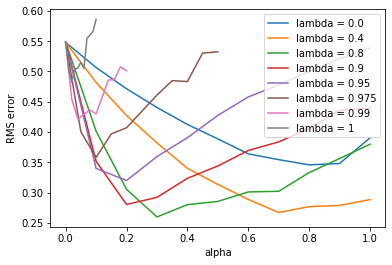

In [11]:
# Figure 12.3: Off-line lambda-return algorithm
def figure_12_3():
    lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
    alphas = [np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 0.55, 0.05),
              np.arange(0, 0.22, 0.02),
              np.arange(0, 0.11, 0.01)]
    parameter_sweep(OffLineLambdaReturn, 50, lambdas, alphas)

figure_12_3()

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


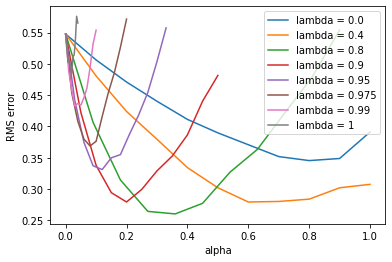

In [12]:
# Figure 12.6: TD(lambda) algorithm
def figure_12_6():
    lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
    alphas = [np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 0.99, 0.09),
              np.arange(0, 0.55, 0.05),
              np.arange(0, 0.33, 0.03),
              np.arange(0, 0.22, 0.02),
              np.arange(0, 0.11, 0.01),
              np.arange(0, 0.044, 0.004)]
    parameter_sweep(TemporalDifferenceLambda, 50, lambdas, alphas)
    
figure_12_6()

100%|██████████| 50/50 [00:39<00:00,  1.32it/s]


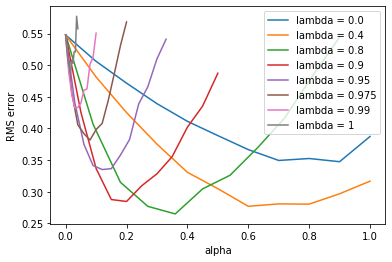

In [13]:
# Figure 12.6: TD(lambda) algorithm
def figure_12_6():
    lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
    alphas = [np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 0.99, 0.09),
              np.arange(0, 0.55, 0.05),
              np.arange(0, 0.33, 0.03),
              np.arange(0, 0.22, 0.02),
              np.arange(0, 0.11, 0.01),
              np.arange(0, 0.044, 0.004)]
    parameter_sweep(TemporalDifferenceLambda, 50, lambdas, alphas)
    
figure_12_6()

## Mountain car problem

In [14]:
#######################################################################
# Following are some utilities for tile coding from Rich.
# To make each file self-contained, I copied them from
# http://incompleteideas.net/tiles/tiles3.py-remove
# with some naming convention changes
#
# Tile coding starts
class IHT:
    "Structure to handle collisions"
    def __init__(self, size_val):
        self.size = size_val
        self.overfull_count = 0
        self.dictionary = {}

    def count(self):
        return len(self.dictionary)

    def full(self):
        return len(self.dictionary) >= self.size

    def get_index(self, obj, read_only=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif read_only:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfull_count == 0: print('IHT full, starting to allow collisions')
            self.overfull_count += 1
            return hash(obj) % self.size
        else:
            d[obj] = count
            return count

def hash_coords(coordinates, m, read_only=False):
    if isinstance(m, IHT): return m.get_index(tuple(coordinates), read_only)
    if isinstance(m, int): return hash(tuple(coordinates)) % m
    if m is None: return coordinates

def tiles(iht_or_size, num_tilings, floats, ints=None, read_only=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    if ints is None:
        ints = []
    qfloats = [floor(f * num_tilings) for f in floats]
    tiles = []
    for tiling in range(num_tilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // num_tilings)
            b += tilingX2
        coords.extend(ints)
        tiles.append(hash_coords(coords, iht_or_size, read_only))
    return tiles
# Tile coding ends
#######################################################################

In [15]:
# all possible actions
ACTION_REVERSE = -1
ACTION_ZERO = 0
ACTION_FORWARD = 1
# order is important
ACTIONS = [ACTION_REVERSE, ACTION_ZERO, ACTION_FORWARD]

# bound for position and velocity
POSITION_MIN = -1.2
POSITION_MAX = 0.5
VELOCITY_MIN = -0.07
VELOCITY_MAX = 0.07

# discount is always 1.0 in these experiments
DISCOUNT = 1.0

# use optimistic initial value, so it's ok to set epsilon to 0
EPSILON = 0

# maximum steps per episode
STEP_LIMIT = 5000

In [16]:
# take an @action at @position and @velocity
# @return: new position, new velocity, reward (always -1)
def step(position, velocity, action):
    new_velocity = velocity + 0.001 * action - 0.0025 * np.cos(3 * position)
    new_velocity = min(max(VELOCITY_MIN, new_velocity), VELOCITY_MAX)
    new_position = position + new_velocity
    new_position = min(max(POSITION_MIN, new_position), POSITION_MAX)
    reward = -1.0
    if new_position == POSITION_MIN:
        new_velocity = 0.0
    return new_position, new_velocity, reward

In [17]:
# accumulating trace update rule
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @return: new trace for convenience
def accumulating_trace(trace, active_tiles, lam):
    trace *= lam * DISCOUNT
    trace[active_tiles] += 1
    return trace

In [18]:
# replacing trace update rule
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @return: new trace for convenience
def replacing_trace(trace, activeTiles, lam):
    active = np.in1d(np.arange(len(trace)), activeTiles)
    trace[active] = 1
    trace[~active] *= lam * DISCOUNT
    return trace

In [19]:
# replacing trace update rule, 'clearing' means set all tiles corresponding to non-selected actions to 0
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @clearingTiles: tiles to be cleared
# @return: new trace for convenience
def replacing_trace_with_clearing(trace, active_tiles, lam, clearing_tiles):
    active = np.in1d(np.arange(len(trace)), active_tiles)
    trace[~active] *= lam * DISCOUNT
    trace[clearing_tiles] = 0
    trace[active] = 1
    return trace

In [27]:
# dutch trace update rule
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @alpha: step size for all tiles
# @return: new trace for convenience
def dutch_trace(trace, active_tiles, lam, alpha):
    coef = 1 - alpha * DISCOUNT * lam * np.sum(trace[active_tiles])
    trace *= DISCOUNT * lam
    trace[active_tiles] += coef
    return trace

In [28]:
# wrapper class for Sarsa(lambda)
class Sarsa:
    # In this example I use the tiling software instead of implementing standard tiling by myself
    # One important thing is that tiling is only a map from (state, action) to a series of indices
    # It doesn't matter whether the indices have meaning, only if this map satisfy some property
    # View the following webpage for more information
    # http://incompleteideas.net/sutton/tiles/tiles3.html
    # @maxSize: the maximum # of indices
    def __init__(self, step_size, lam, trace_update=accumulating_trace, num_of_tilings=8, max_size=2048):
        self.max_size = max_size
        self.num_of_tilings = num_of_tilings
        self.trace_update = trace_update
        self.lam = lam

        # divide step size equally to each tiling
        self.step_size = step_size / num_of_tilings

        self.hash_table = IHT(max_size)

        # weight for each tile
        self.weights = np.zeros(max_size)

        # trace for each tile
        self.trace = np.zeros(max_size)

        # position and velocity needs scaling to satisfy the tile software
        self.position_scale = self.num_of_tilings / (POSITION_MAX - POSITION_MIN)
        self.velocity_scale = self.num_of_tilings / (VELOCITY_MAX - VELOCITY_MIN)

    # get indices of active tiles for given state and action
    def get_active_tiles(self, position, velocity, action):
        # I think positionScale * (position - position_min) would be a good normalization.
        # However positionScale * position_min is a constant, so it's ok to ignore it.
        active_tiles = tiles(self.hash_table, self.num_of_tilings,
                            [self.position_scale * position, self.velocity_scale * velocity],
                            [action])
        return active_tiles

    # estimate the value of given state and action
    def value(self, position, velocity, action):
        if position == POSITION_MAX:
            return 0.0
        active_tiles = self.get_active_tiles(position, velocity, action)
        return np.sum(self.weights[active_tiles])

    # learn with given state, action and target
    def learn(self, position, velocity, action, target):
        active_tiles = self.get_active_tiles(position, velocity, action)
        estimation = np.sum(self.weights[active_tiles])
        delta = target - estimation
        if self.trace_update == accumulating_trace or self.trace_update == replacing_trace:
            self.trace_update(self.trace, active_tiles, self.lam)
        elif self.trace_update == dutch_trace:
            self.trace_update(self.trace, active_tiles, self.lam, self.step_size)
        elif self.trace_update == replacing_trace_with_clearing:
            clearing_tiles = []
            for act in ACTIONS:
                if act != action:
                    clearing_tiles.extend(self.get_active_tiles(position, velocity, act))
            self.trace_update(self.trace, active_tiles, self.lam, clearing_tiles)
        else:
            raise Exception('Unexpected Trace Type')
        self.weights += self.step_size * delta * self.trace

    # get # of steps to reach the goal under current state value function
    def cost_to_go(self, position, velocity):
        costs = []
        for action in ACTIONS:
            costs.append(self.value(position, velocity, action))
        return -np.max(costs)

In [29]:
# get action at @position and @velocity based on epsilon greedy policy and @valueFunction
def get_action(position, velocity, valueFunction):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    values = []
    for action in ACTIONS:
        values.append(valueFunction.value(position, velocity, action))
    return np.argmax(values) - 1

In [30]:
# play Mountain Car for one episode based on given method @evaluator
# @return: total steps in this episode
def play(evaluator):
    position = np.random.uniform(-0.6, -0.4)
    velocity = 0.0
    action = get_action(position, velocity, evaluator)
    steps = 0
    while True:
        next_position, next_velocity, reward = step(position, velocity, action)
        next_action = get_action(next_position, next_velocity, evaluator)
        steps += 1
        target = reward + DISCOUNT * evaluator.value(next_position, next_velocity, next_action)
        evaluator.learn(position, velocity, action, target)
        position = next_position
        velocity = next_velocity
        action = next_action
        if next_position == POSITION_MAX:
            break
        if steps >= STEP_LIMIT:
            print('Step Limit Exceeded!')
            break
    return steps

 73%|███████▎  | 22/30 [00:37<00:12,  1.53s/it]

Step Limit Exceeded!


 77%|███████▋  | 23/30 [00:39<00:10,  1.56s/it]

Step Limit Exceeded!


  0%|          | 0/30 [00:00<?, ?it/s]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


  3%|▎         | 1/30 [00:27<13:10, 27.27s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


  7%|▋         | 2/30 [00:37<10:18, 22.09s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 10%|█         | 3/30 [00:59<09:55, 22.07s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 13%|█▎        | 4/30 [01:16<08:52, 20.49s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 17%|█▋        | 5/30 [01:40<08:58, 21.53s/it]

Step Limit Exceeded!
Step Limit Exceeded!


 20%|██        | 6/30 [01:44<06:36, 16.50s/it]

Step Limit Exceeded!


 27%|██▋       | 8/30 [01:49<03:21,  9.16s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 33%|███▎      | 10/30 [01:59<02:17,  6.88s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 37%|███▋      | 11/30 [02:21<03:37, 11.44s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 40%|████      | 12/30 [02:29<03:08, 10.44s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 43%|████▎     | 13/30 [02:46<03:30, 12.40s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 47%|████▋     | 14/30 [03:11<04:18, 16.13s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 50%|█████     | 15/30 [03:26<03:58, 15.92s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 57%|█████▋    | 17/30 [03:33<02:02,  9.41s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 60%|██████    | 18/30 [03:42<01:53,  9.50s/it]

Step Limit Exceeded!


 63%|██████▎   | 19/30 [03:44<01:18,  7.10s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 67%|██████▋   | 20/30 [03:55<01:21,  8.16s/it]

Step Limit Exceeded!


 73%|███████▎  | 22/30 [03:58<00:39,  4.88s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 77%|███████▋  | 23/30 [04:08<00:44,  6.29s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 80%|████████  | 24/30 [04:34<01:14, 12.37s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 87%|████████▋ | 26/30 [04:40<00:29,  7.47s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 90%|█████████ | 27/30 [04:51<00:25,  8.55s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 93%|█████████▎| 28/30 [05:28<00:34, 17.12s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 97%|█████████▋| 29/30 [05:36<00:14, 14.40s/it]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


  0%|          | 0/30 [00:00<?, ?it/s]

Step Limit Exceeded!


100%|██████████| 30/30 [00:54<00:00,  1.80s/it]


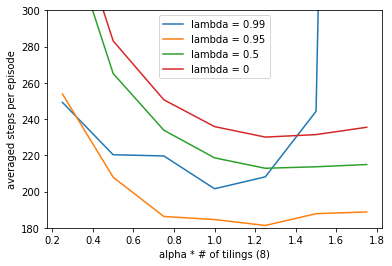

In [33]:
# figure 12.10, effect of the lambda and alpha on early performance of Sarsa(lambda)
def figure_12_10():
    runs = 30
    episodes = 50
    alphas = np.arange(1, 8) / 4.0
    lams = [0.99, 0.95, 0.5, 0]

    steps = np.zeros((len(lams), len(alphas), runs, episodes))
    for lamInd, lam in enumerate(lams):
        for alphaInd, alpha in enumerate(alphas):
            for run in tqdm(range(runs)):
                evaluator = Sarsa(alpha, lam, replacing_trace)
                for ep in range(episodes):
                    step = play(evaluator)
                    steps[lamInd, alphaInd, run, ep] = step

    # average over episodes
    steps = np.mean(steps, axis=3)

    # average over runs
    steps = np.mean(steps, axis=2)

    for lamInd, lam in enumerate(lams):
        plt.plot(alphas, steps[lamInd, :], label='lambda = %s' % (str(lam)))
    plt.xlabel('alpha * # of tilings (8)')
    plt.ylabel('averaged steps per episode')
    plt.ylim([180, 300])
    plt.legend()

figure_12_10()

100%|██████████| 30/30 [00:00<00:00, 29585.97it/s]


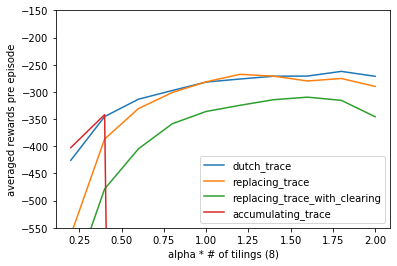

In [34]:
# figure 12.11, summary comparision of Sarsa(lambda) algorithms
# I use 8 tilings rather than 10 tilings
def figure_12_11():
    traceTypes = [dutch_trace, replacing_trace, replacing_trace_with_clearing, accumulating_trace]
    alphas = np.arange(0.2, 2.2, 0.2)
    episodes = 20
    runs = 30
    lam = 0.9
    rewards = np.zeros((len(traceTypes), len(alphas), runs, episodes))

    for traceInd, trace in enumerate(traceTypes):
        for alphaInd, alpha in enumerate(alphas):
            for run in tqdm(range(runs)):
                evaluator = Sarsa(alpha, lam, trace)
                for ep in range(episodes):
                    if trace == accumulating_trace and alpha > 0.6:
                        steps = STEP_LIMIT
                    else:
                        steps = play(evaluator)
                    rewards[traceInd, alphaInd, run, ep] = -steps

    # average over episodes
    rewards = np.mean(rewards, axis=3)

    # average over runs
    rewards = np.mean(rewards, axis=2)

    for traceInd, trace in enumerate(traceTypes):
        plt.plot(alphas, rewards[traceInd, :], label=trace.__name__)
    plt.xlabel('alpha * # of tilings (8)')
    plt.ylabel('averaged rewards pre episode')
    plt.ylim([-550, -150])
    plt.legend()
    
figure_12_11()